In [1]:
%load_ext autoreload
%autoreload 2

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import eleanor
import lightkurve as lk
import copy
import scipy.fftpack as sfft
from scipy.optimize import minimize
from scipy.ndimage import zoom
from skimage import restoration
import tqdm
from stemtool.afit import mpfit
assert "pals" in eleanor.__file__

In [45]:
star = eleanor.Source(tic=120362128, sector=14, tc=True)
star.premade = False
data = eleanor.TargetData(star, height=15, width=15, do_pca=True, do_psf=False)
sc = lk.search_targetpixelfile(target='tic120362128', sector=14).download()
sq = sc.quality < 5000
start = 2500
end = 3400
tpfs = sc.flux[sq][start:end].value
errs = sc.flux_err[sq][start:end].value
bkgs = sc.flux_bkg[sq,0,0][start:end].value
bkg0 = np.mean(bkgs)
xc = [4.9, 4.5, 4.7]
yc = [3.0, 4.4, 7.0]
nstars = len(xc)
mean_tpf = np.mean(tpfs, axis=0)
mean_err = np.mean(errs, axis=0)

model = eleanor.models.Gaussian(
    shape=tpfs.shape[1:], 
    col_ref=0, 
    row_ref=0, 
    xc = xc,
    yc = yc,
    nstars = nstars,
    fit_idx = 0,
    bkg0 = bkg0
)

In [46]:
fluxes = np.max(tpfs[0]) * np.ones(nstars,) # flux of each star
globalpars = np.array([0, 0, bkgs[0]]) # xshift, yshift of target star; background
optpars = model.get_default_optpars() # model-specific optimization parameters
par = np.concatenate((fluxes, globalpars, optpars))

def nll(params, frame, err):
    for j, p in enumerate(params):
        if not(model.bounds[j, 0] <= p and p <= model.bounds[j, 1]):
            return np.infty

    fluxes = params[:nstars]
    xshift, yshift, bkg = params[nstars:nstars+3]
    optpars = params[nstars+3:]
    mean_val = model.mean(fluxes, xshift, yshift, bkg, optpars)
    res = mean_val - frame
    res_mean, res_sd = np.mean(res), np.std(res)
    res_ll = np.sum(((res - res_mean) / res_sd) ** 2)

    return np.sum((mean_val - frame) ** 2 / err)

par = minimize(nll, par, (mean_tpf, mean_err), tol=1e-4).x

In [47]:
par[nstars+3:]

array([ 0.72475287, -0.17225341,  0.87888264])

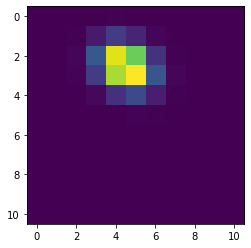

In [48]:
plt.imshow(model(par[0], xc[0] + par[nstars], yc[0] + par[nstars+1], par[nstars+3:]))

In [49]:

aperture_fluxes = data.get_aperture_fluxes(xc=xc, yc=yc, data_arr=tpfs)

In [82]:
 mean_xs, mean_ys = par[nstars:nstars+2]
 mean_pars = par[nstars+3:]
 
 def psf_deltas(xc, yc, mags):
    """Ideal TPF given a known/fitted PSF for a particular cadence."""
    mock_data = np.zeros_like(tpfs[0])
    for (x, y, m) in zip(xc, yc, mags):
        mock_data += model(m, mean_xs, mean_ys, mean_pars)
    return mock_data

In [83]:
def fluxes_arma(kernel=np.array([1, 2, 4, 2, 1])):
    assert len(kernel) % 2 == 1, "must have a symmetric kernel"
    half_len = len(kernel) // 2
    kernel = kernel / sum(kernel)
    model_fluxes = np.empty_like(aperture_fluxes)
    for i in range(aperture_fluxes.shape[1]):
        conv_result = np.convolve(kernel, aperture_fluxes[:,i])[2 * half_len:-2 * half_len]
        model_fluxes[:half_len,i] = aperture_fluxes[:half_len,i]
        model_fluxes[half_len:-half_len,i] = conv_result
        model_fluxes[-half_len:,i] = aperture_fluxes[-half_len,i]

    return model_fluxes

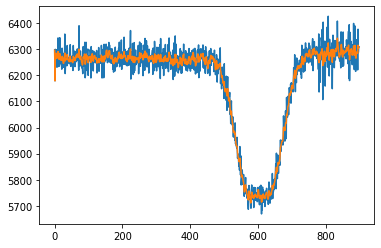

In [99]:
fluxes_test = fluxes_arma()
plt.plot(aperture_fluxes[:,0])
plt.plot(fluxes_test[:,0])

In [85]:
def make_model_tpfs(kernel):
    model_fluxes = fluxes_arma(np.array(kernel))
    return np.array([psf_deltas(xc, yc, mags) for mags in model_fluxes])

def tpf_loss(kernel):
    model_tpfs = make_model_tpfs(kernel)
    return np.sum((model_tpfs - tpfs) ** 2)

In [95]:
res = minimize(tpf_loss, [1, 2, 4, 2, 1], method='Nelder-Mead', tol=1e-4)

In [94]:
res

      fun: 938805360000.0
 hess_inv: array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])
      jac: array([0., 0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1., 2., 4., 2., 1.])

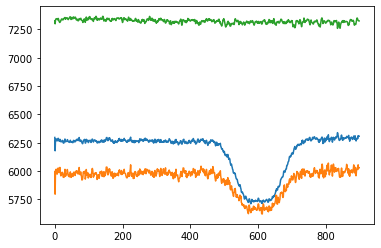

In [96]:
plt.plot(fluxes_arma(res.x))

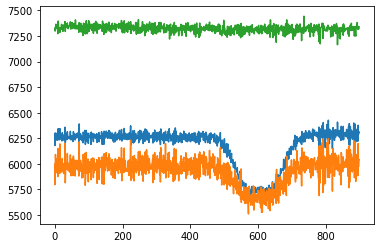

In [97]:
plt.plot(aperture_fluxes)

In [55]:
data.get_lightcurve()

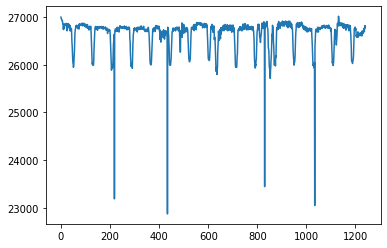

In [56]:
plt.plot(data.corr_flux)

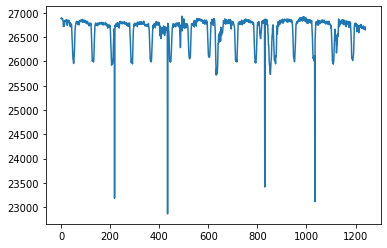

In [57]:
plt.plot(data.pca_flux)

In [58]:
data.corrected_flux()

masked_array(data=[26999.83743941, 26984.67899173, 26956.0520887 , ...,
                   26817.80109719, 26770.53224024, 26808.98098696],
             mask=False,
       fill_value=1e+20)